<a href="https://colab.research.google.com/github/wanjanhasan/non-obviousEmotionDetection/blob/main/non_obviousEmotionDetectionFromText_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing necessary utilities (Must be run for all the cells)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.stats import kurtosis
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import svm
from sklearn.metrics import classification_report

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, Embedding, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Initialization

##Loading Data (Must be run for all the cells)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
semeval = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/SemEval2022_En.csv')
tweet = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/tweet_emotions.csv')
liar=pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/liar_complete.tsv', sep='\t')

In [ ]:
"""semeval = pd.read_json('/content/Sarcasm_Headlines_Dataset.json', lines=True)
semeval.head()"""

"semeval = pd.read_json('/content/Sarcasm_Headlines_Dataset.json', lines=True)\nsemeval.head()"

##Preprocessing (Must be run for all the cells)

To achieve binary classification, each of the statements of the dataframe for liar dataset is classified as either 1 or 0. This is done with the help of an additional feature, Label_enc, where: 
1 = TRUE/mostly-true/half-true
0 = pants-fire/FALSE/barely-true

###**Before**

**liar dataset**

In [ ]:
(liar['Label']=="FALSE").value_counts()[True]+(liar['Label']=="pants-fire").value_counts()[True]+(liar['Label']=="barely-true").value_counts()[True]

5657

In [ ]:
liar['Label'].value_counts()

half-true      2627
FALSE          2507
mostly-true    2454
barely-true    2103
TRUE           2053
pants-fire     1047
Name: Label, dtype: int64

Text(0.5, 1.0, 'liar Data Distribution')

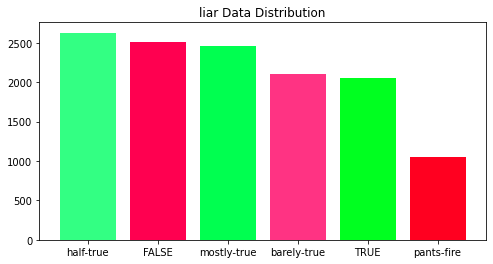

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(liar['Label'].value_counts().index, liar['Label'].value_counts().values, 
        color=['#33ff83', '#ff0050', '#00ff50', '#ff3383', '#00ff20', '#ff0020'])
plt.title("liar Data Distribution")

**tweet dataset**

In [ ]:
tweet.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
tweet['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'tweet emotions Data Distribution')

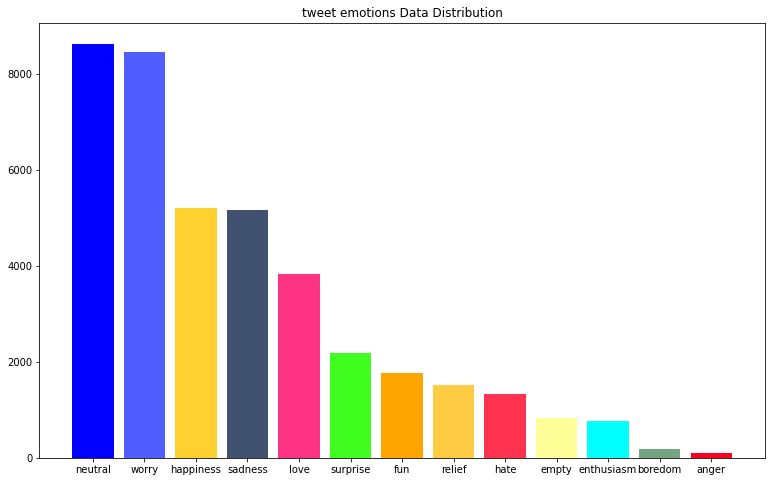

In [ ]:
plt.figure(figsize=(13,8))
plt.bar(tweet['sentiment'].value_counts().index, tweet['sentiment'].value_counts().values, 
        color=['blue', '#505eff', '#ffd130', '#405270', '#ff3383', '#40ff20', '#ffa500', 
               '#ffcc43', '#ff3350', '#ffff99', '#00ffff', '#76a381', '#ff0020'])
plt.title("tweet emotions Data Distribution")

**semeval dataset**

In [ ]:
semeval.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
semeval['sarcastic'].value_counts()

0    2601
1     867
Name: sarcastic, dtype: int64

In [ ]:
semeval['rephrase'].isnull().value_counts()

True     2601
False     867
Name: rephrase, dtype: int64

Text(0.5, 1.0, 'sarcastic Data Distribution (0=non-sarcastic, 1=sarcastic)')

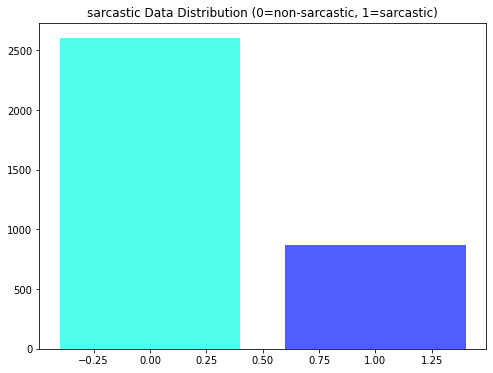

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(semeval['sarcastic'].value_counts().index, semeval['sarcastic'].value_counts().values, 
        color=['#50ffed', '#505eff'])
plt.title("sarcastic Data Distribution (0=non-sarcastic, 1=sarcastic)")

###**After**

Here, all the True and False statements will be combined to gather more data. Assumptions made in every step has been mentioned before each block

In [ ]:
modifiedLiar=liar[['TheStatement', 'Label']]
modifiedLiar.head()

,TheStatement,Label
0,Wisconsin is on pace to double the number of l...,FALSE
1,Says John McCain has done nothing to help the ...,FALSE
2,Suzanne Bonamici supports a plan that will cut...,half-true
3,When asked by a reporter whether hes at the ce...,pants-fire
4,Over the past five years the federal governmen...,TRUE


In [ ]:
modifiedLiar.insert(2, "LabelModified", "")
modifiedLiar.head()

,TheStatement,Label,LabelModified
0,Wisconsin is on pace to double the number of l...,FALSE,
1,Says John McCain has done nothing to help the ...,FALSE,
2,Suzanne Bonamici supports a plan that will cut...,half-true,
3,When asked by a reporter whether hes at the ce...,pants-fire,
4,Over the past five years the federal governmen...,TRUE,


In [ ]:
for i in range(len(modifiedLiar)):
  if ((modifiedLiar.loc[i, "Label"]=="FALSE") | (modifiedLiar.loc[i, "Label"]=="barely-true") | (modifiedLiar.loc[i, "Label"]=="pants-fire")):
    modifiedLiar.loc[i, "LabelModified"]="FALSE"
  else:
    modifiedLiar.loc[i, "LabelModified"]="TRUE"
modifiedLiar.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,TheStatement,Label,LabelModified
0,Wisconsin is on pace to double the number of l...,FALSE,FALSE
1,Says John McCain has done nothing to help the ...,FALSE,FALSE
2,Suzanne Bonamici supports a plan that will cut...,half-true,TRUE
3,When asked by a reporter whether hes at the ce...,pants-fire,FALSE
4,Over the past five years the federal governmen...,TRUE,TRUE


In [ ]:
modifiedLiar.describe()

,TheStatement,Label,LabelModified
count,12791,12791,12791
unique,12765,6,2
top,On a cap-and-trade plan.,half-true,TRUE
freq,3,2627,7134


**modifiedSemeval_sarcasms=labels of the rephrased statements (All the rephrased statements are considered to be truths and the ones where rephrase are absent will be dropped in the sub dataset) that is to be used for training liar model (0=Lie, 1=True)**

In [ ]:
modifiedSemeval_sarcasms=semeval[['tweet', 'sarcastic']]
modifiedSemeval_rephrases=semeval[['rephrase']]

Dropping all the rows that contain no rephrases (for sarcasms only)

In [ ]:
modifiedSemeval_rephrases.isna().value_counts()

rephrase
True        2601
False        867
dtype: int64

In [ ]:
modifiedSemeval_rephrases=modifiedSemeval_rephrases.dropna()
modifiedSemeval_rephrases.shape

(867, 1)

In [ ]:
#modifiedSemeval_sarcasms.dtypes

In [ ]:
modifiedSemeval_sarcasms.insert(2, "LabelModified", "")
modifiedSemeval_rephrases.insert(1, "sarcastic", "")
modifiedSemeval_rephrases.insert(2, "LabelModified", "")

In [ ]:
#modifiedSemeval_sarcasms.head()

In [ ]:
for i in range(len(modifiedSemeval_sarcasms)):
  if modifiedSemeval_sarcasms.loc[i, "sarcastic"]==1:
    modifiedSemeval_sarcasms.loc[i, "LabelModified"]="FALSE"
  else:
    modifiedSemeval_sarcasms.loc[i, "LabelModified"]="TRUE"

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Text(0.5, 1.0, 'sarcastic Data Distribution (TRUE=non-sarcastic, FALSE=sarcastic)')

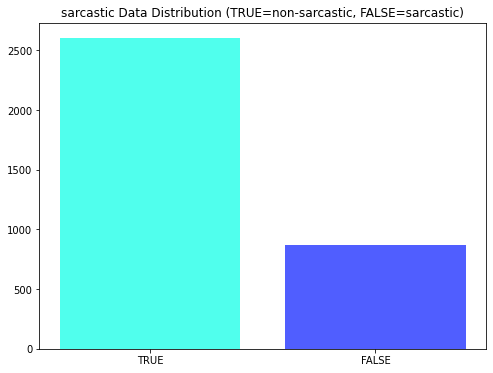

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(modifiedSemeval_sarcasms['LabelModified'].value_counts().index, modifiedSemeval_sarcasms['LabelModified'].value_counts().values, 
        color=['#50ffed', '#505eff'])
plt.title("sarcastic Data Distribution (TRUE=non-sarcastic, FALSE=sarcastic)")

In [ ]:
modifiedSemeval_sarcasms.head()

,tweet,sarcastic,LabelModified
0,The only thing I got from college is a caffein...,1,FALSE
1,I love it when professors draw a big question ...,1,FALSE
2,Remember the hundred emails from companies whe...,1,FALSE
3,Today my pop-pop told me I was not “forced” to...,1,FALSE
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,FALSE


In [ ]:
#modifiedSemeval_rephrases.head()

In [ ]:
for i in range(len(modifiedSemeval_rephrases)):
  modifiedSemeval_rephrases.loc[i, "sarcastic"]=0
  modifiedSemeval_rephrases.loc[i, "LabelModified"]="TRUE"
modifiedSemeval_rephrases.head()

,rephrase,sarcastic,LabelModified
0,"College is really difficult, expensive, tiring...",0,TRUE
1,I do not like when professors don’t write out ...,0,TRUE
2,"I, at the bare minimum, wish companies actuall...",0,TRUE
3,"Today my pop-pop told me I was not ""forced"" to...",0,TRUE
4,I would say Ted Cruz is an asshole and doesn’t...,0,TRUE


Text(0.5, 1.0, 'Rephrases Data Distribution (TRUE=non-sarcastic, FALSE=sarcastic)')

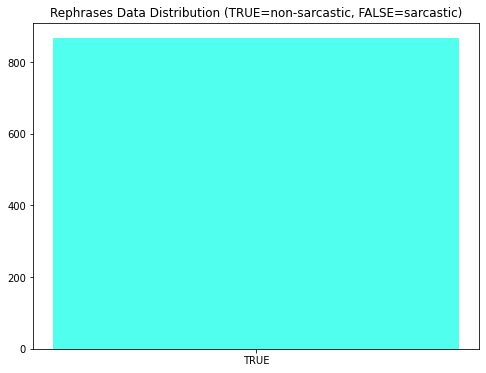

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(modifiedSemeval_rephrases['LabelModified'].value_counts().index, modifiedSemeval_rephrases['LabelModified'].value_counts().values, 
        color=['#50ffed'])
plt.title("Rephrases Data Distribution (TRUE=non-sarcastic, FALSE=sarcastic)")

**tweet dataset**

In [ ]:
tweet.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
modifiedTweet=tweet[['content', 'sentiment']]
modifiedTweet.head()

,content,sentiment
0,@tiffanylue i know i was listenin to bad habi...,empty
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,@dannycastillo We want to trade with someone w...,neutral


In [ ]:
modifiedTweet.insert(2, "LabelModified", "")

In [ ]:
for i in range(len(modifiedTweet)):
  modifiedTweet.loc[i, "LabelModified"]="TRUE"
modifiedTweet.head()

,content,sentiment,LabelModified
0,@tiffanylue i know i was listenin to bad habi...,empty,TRUE
1,Layin n bed with a headache ughhhh...waitin o...,sadness,TRUE
2,Funeral ceremony...gloomy friday...,sadness,TRUE
3,wants to hang out with friends SOON!,enthusiasm,TRUE
4,@dannycastillo We want to trade with someone w...,neutral,TRUE


Appending the modifiedSemeval_sarcasms, modifiedSemeval_rephrases, and modifiedTweet to combinedLiar for more data.


**Problem:** Too many truths

In [ ]:
combined=np.concatenate((modifiedLiar.values, modifiedSemeval_sarcasms.values, modifiedSemeval_rephrases.values, modifiedTweet.values), axis=0)
combined.shape

(57126, 3)

In [ ]:
combinedLiar=pd.DataFrame(combined, columns=["TheStatement", "oldLabel", "Label"])

In [ ]:
combinedLiar.head()

,TheStatement,oldLabel,Label
0,Wisconsin is on pace to double the number of l...,FALSE,FALSE
1,Says John McCain has done nothing to help the ...,FALSE,FALSE
2,Suzanne Bonamici supports a plan that will cut...,half-true,TRUE
3,When asked by a reporter whether hes at the ce...,pants-fire,FALSE
4,Over the past five years the federal governmen...,TRUE,TRUE


Encoding the values to zeros and ones

In [ ]:
enc = preprocessing.LabelEncoder()

# Apply the encoding to the "Accessible" column
combinedLiar['Label_enc'] = enc.fit_transform(combinedLiar['Label'])

# Compare the two columns
print(combinedLiar[['Label', 'Label_enc']].head())

   Label  Label_enc
0  FALSE          0
1  FALSE          0
2   TRUE          1
3  FALSE          0
4   TRUE          1


In [ ]:
combinedLiar.describe()

,Label_enc
count,57126.000000
mean,0.885796
std,0.318061
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


Text(0.5, 1.0, 'combinedLiar Data Distribution')

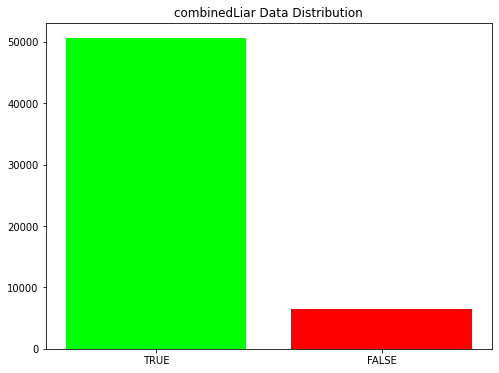

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(combinedLiar['Label'].value_counts().index, combinedLiar['Label'].value_counts().values, 
        color=['#00ff00', '#ff0000'])
plt.title("combinedLiar Data Distribution")

In [ ]:
combinedLiar['Label'].value_counts()

TRUE     50602
FALSE     6524
Name: Label, dtype: int64

In [ ]:
print(skew(combinedLiar['Label_enc'], axis=0, bias=True))

-2.425945629731081


Negative Skewness. So the data is distributed in such a way that the tail of the left side of the distribution is longer or fatter than the tail on the right side. 

So, the mean and median is less than the mode.

In [ ]:
print(kurtosis(combinedLiar['Label_enc'], axis=0, bias=True))

3.8852121984113257


kurtosis>0. So, leptokurtic. not playkurtic

##Cleaning up the dataset (Must be run for all the cells)

Stemming

In [ ]:
stop_words = stopwords.words('english')  #cleaning the stopwords that worsen the result
stemmer = SnowballStemmer('english')    #stemming each word
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(statements, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(statements).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
combinedLiar.text = combinedLiar.TheStatement.apply(lambda x: preprocess(x))

<ipython-input-46-2bb4b3ad6cd2>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  combinedLiar.text = combinedLiar.TheStatement.apply(lambda x: preprocess(x))


##housekeeping and Word visuals

In [ ]:
combinedLiar=combinedLiar.dropna() #a value was nan before, so had to drop it

In [ ]:
combinedLiar.shape

(57125, 4)

##Preparing the test and dev sets

In [ ]:
combinedLiar.columns

Index(['TheStatement', 'oldLabel', 'Label', 'Label_enc'], dtype='object')

In [ ]:
combinedLiarTrain, combinedLiarTest = train_test_split(combinedLiar, test_size=0.2, random_state=40)
#liarXTrain, liarXTest, liarYTrain, liarYTest = train_test_split(liarX, liarY, test_size=0.25, random_state=42)

In [ ]:
combinedLiar.shape

(57125, 4)

In [ ]:
print("Shape of liar train portion for features: {}".format(combinedLiarTrain.shape)) 
print("Shape of liar test portion for features: {}".format(combinedLiarTest.shape)) 

Shape of liar train portion for features: (45700, 4)
Shape of liar test portion for features: (11425, 4)


##Early Stopping and ReduceLROnPlateau functions

In [ ]:
EarlyStopping =EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

##Functions to calculate recall, precision and f1

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Model for lie detection

###**generating visualization for the false and then true sentiments**

wordcloud on pure liar dataset

In [ ]:
liar.columns

Index(['[ID].json', 'Label', 'TheStatement', 'The subject(s)', 'The speaker',
       'The speaker's job title', 'The state info.', 'The party affiliation',
       'Barely true counts', 'False counts', 'Half true counts',
       'Mostly true counts', 'Pants on fire counts', 'The context'],
      dtype='object')

In [ ]:
"""from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(liar[liar.Label_enc == 0].TheStatement))
plt.imshow(wc , interpolation = 'bilinear')"""

'from wordcloud import WordCloud\n\nplt.figure(figsize = (20,20)) \nwc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(liar[liar.Label_enc == 0].TheStatement))\nplt.imshow(wc , interpolation = \'bilinear\')'

In [ ]:
"""from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(liar[liar.Label_enc == 1].TheStatement))
plt.imshow(wc , interpolation = 'bilinear')"""

'from wordcloud import WordCloud\n\nplt.figure(figsize = (20,20)) \nwc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(liar[liar.Label_enc == 1].TheStatement))\nplt.imshow(wc , interpolation = \'bilinear\')'

wordcloud for combined liar dataset

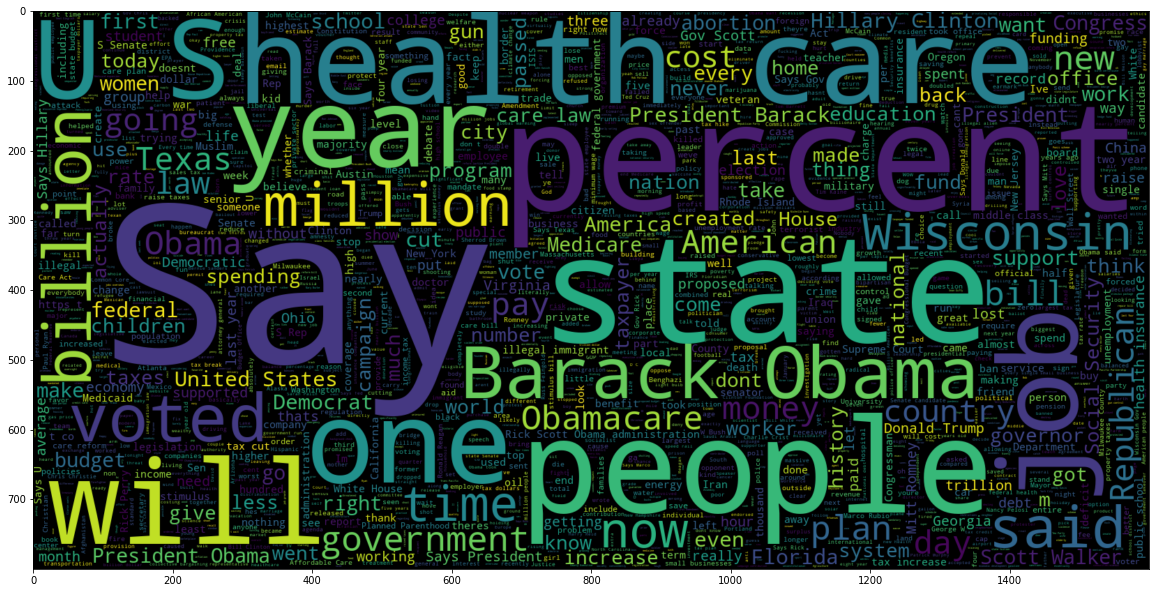

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(combinedLiar[combinedLiar.Label_enc == 0].TheStatement))
plt.imshow(wc , interpolation = 'bilinear')

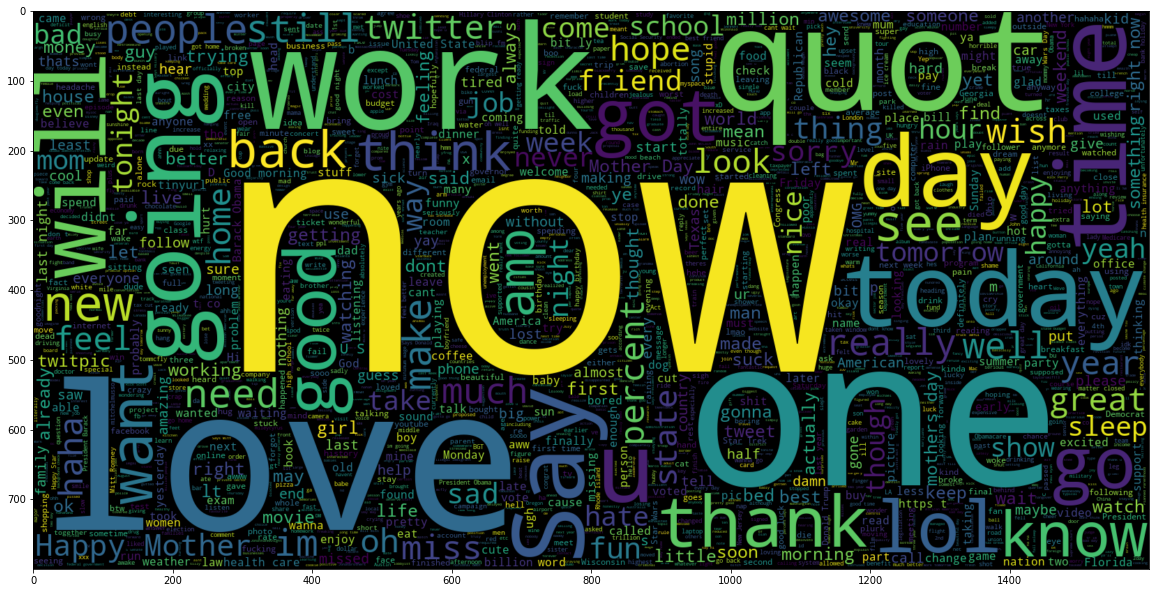

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(combinedLiar[combinedLiar.Label_enc == 1].TheStatement))
plt.imshow(wc , interpolation = 'bilinear')

##**SVM on combinedLiar dataset**

In [ ]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(combinedLiarTrain['TheStatement'])
test_vectors = vectorizer.transform(combinedLiarTest['TheStatement'])

In [ ]:
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, combinedLiarTrain['Label_enc'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(combinedLiarTest['Label_enc'], prediction_linear, output_dict=True)
print('True: ', report['1'])
print('False: ', report['0'])
print(accuracy_score(combinedLiarTest['Label_enc'], prediction_linear))

Training time: 159.844696s; Prediction time: 17.122505s
True:  {'precision': 0.9110619060798967, 'recall': 0.9764659349352319, 'f1-score': 0.9426307751050019, 'support': 10113}
False:  {'precision': 0.5938566552901023, 'recall': 0.2652439024390244, 'f1-score': 0.36670179135932557, 'support': 1312}
0.8947921225382932


##**LSTM**

###Preprocessing

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(combinedLiarTrain.TheStatement)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 51924


In [ ]:
MAX_SEQUENCE_LENGTH = 30
combinedLiarXTrain = pad_sequences(tokenizer.texts_to_sequences(combinedLiarTrain.TheStatement),
                        maxlen = MAX_SEQUENCE_LENGTH)
combinedLiarXTest = pad_sequences(tokenizer.texts_to_sequences(combinedLiarTest.TheStatement),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",combinedLiarXTrain.shape)
print("Testing X Shape:",combinedLiarXTest.shape)

Training X Shape: (45700, 30)
Testing X Shape: (11425, 30)


In [ ]:
labels = combinedLiarTrain.Label_enc.unique().tolist()

In [ ]:
encoder = preprocessing.LabelEncoder()
encoder.fit(combinedLiarTrain.Label_enc.to_list())

combinedLiarYTrain = encoder.transform(combinedLiarTrain.Label_enc.to_list())
combinedLiarYTest = encoder.transform(combinedLiarTest.Label_enc.to_list())

combinedLiarYTrain = combinedLiarYTrain.reshape(-1,1)
combinedLiarYTest = combinedLiarYTest.reshape(-1,1)

print("combinedLiarYTrain shape:", combinedLiarYTrain.shape)
print("combinedLiarYTestt shape:", combinedLiarYTest.shape)

combinedLiarYTrain shape: (45700, 1)
combinedLiarYTestt shape: (11425, 1)


Transfer Learning

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [ ]:
#!ls
#!pwd

In [ ]:
#indexing word vectors

embeddings_index = {}
f = open('/content/drive/MyDrive/Thesis/Datasets/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


LSTM implement

###Word Embedding

In [ ]:
EMBEDDING_DIM = 300

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

###Building the model

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(624, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1500, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='tanh')(x)

By using Model library and compiling with Adam optimizer, **LR**=____, loss function=binary_crossentropy 

In [ ]:
LR = 1e-3

In [ ]:
liarModelEarlyStopping = tf.keras.Model(sequence_input, outputs)
liarModelEarlyStopping.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['acc', f1_m, precision_m , recall_m])

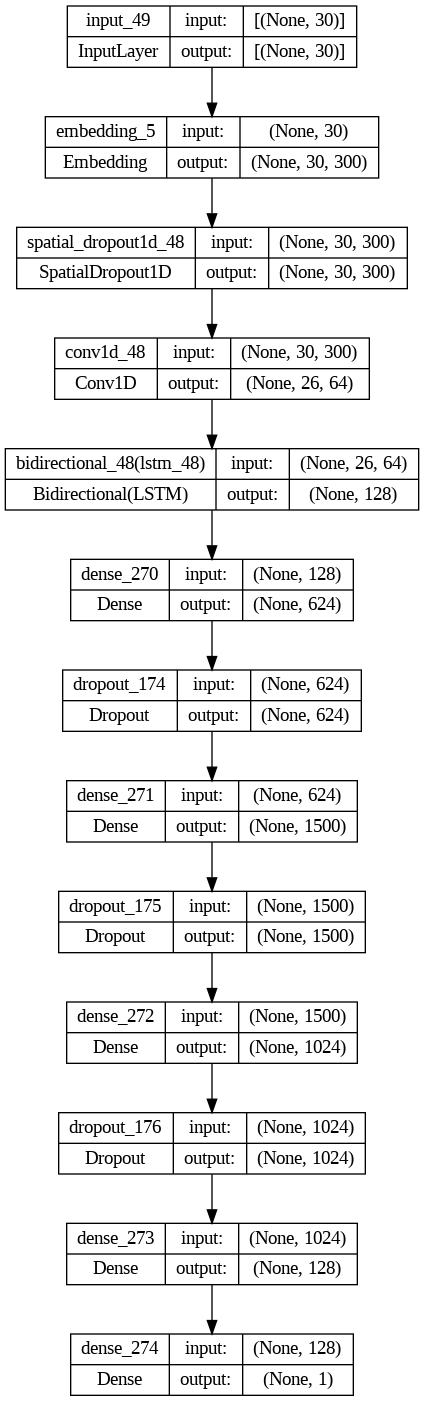

In [ ]:
plot_model(liarModelEarlyStopping, "liarModelEarlyStoppingArchitecture.png", show_shapes=True)

In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


In [ ]:
BATCH_SIZE = 1500
EPOCHS = 35

###Training With EarlyStopping

In [ ]:
combinedLiarXTrain.shape

(45700, 30)

In [ ]:
historyLiarEarlyStopping = liarModelEarlyStopping.fit(combinedLiarXTrain, combinedLiarYTrain, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(combinedLiarXTest, combinedLiarYTest), callbacks=EarlyStopping)

Epoch 1/35
31/31 [==============================] - 16s 355ms/step - loss: 0.6085 - acc: 0.8530 - f1_m: 0.9046 - precision_m: 0.8562 - recall_m: 0.9591 - val_loss: 0.3138 - val_acc: 0.8558 - val_f1_m: 0.9173 - val_precision_m: 0.9265 - val_recall_m: 0.9084
Epoch 2/35
31/31 [==============================] - 8s 252ms/step - loss: 0.2691 - acc: 0.8831 - f1_m: 0.9374 - precision_m: 0.8909 - recall_m: 0.9891 - val_loss: 0.2597 - val_acc: 0.8674 - val_f1_m: 0.9245 - val_precision_m: 0.9289 - val_recall_m: 0.9202
Epoch 3/35
31/31 [==============================] - 8s 258ms/step - loss: 0.2468 - acc: 0.8849 - f1_m: 0.9381 - precision_m: 0.8971 - recall_m: 0.9834 - val_loss: 0.2475 - val_acc: 0.8656 - val_f1_m: 0.9219 - val_precision_m: 0.9475 - val_recall_m: 0.8976
Epoch 4/35
31/31 [==============================] - 8s 258ms/step - loss: 0.2366 - acc: 0.8884 - f1_m: 0.9395 - precision_m: 0.9058 - recall_m: 0.9760 - val_loss: 0.2350 - val_acc: 0.8859 - val_f1_m: 0.9362 - val_precision_m: 0.923

In [ ]:
loss, acc, f1_score, precision, recall = liarModelEarlyStopping.evaluate(combinedLiarXTest, combinedLiarYTest, verbose=2)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("f1 score: {}".format(f1_score))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

358/358 - 5s - loss: 0.2265 - acc: 0.8897 - f1_m: 0.9381 - precision_m: 0.9222 - recall_m: 0.9568 - 5s/epoch - 14ms/step
Loss: 0.22646287083625793
Accuracy: 0.8897155523300171
f1 score: 0.9381453990936279
Precision: 0.9222072958946228
Recall: 0.9567506313323975


In [ ]:
print(liarModelEarlyStopping.summary())

Model Evaluating

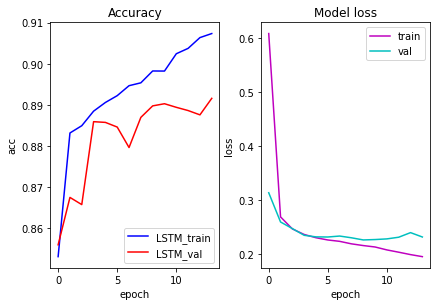

In [ ]:
s, (at, al) = plt.subplots(1,2)
s.tight_layout()
at.plot(historyLiarEarlyStopping.history['acc'], c= 'b')
at.plot(historyLiarEarlyStopping.history['val_acc'], c='r')
at.set_title('Accuracy')
at.set_ylabel('acc')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='lower right')

al.plot(historyLiarEarlyStopping.history['loss'], c='m')
al.plot(historyLiarEarlyStopping.history['val_loss'], c='c')
al.set_title('Model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper right')

###Training With ReduceLRonPlateau

In [ ]:
liarModelReduceLROnPlateau = tf.keras.Model(sequence_input, outputs)
liarModelReduceLROnPlateau.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['acc', f1_m, precision_m , recall_m])

In [ ]:
historyLiarReduceLROnPlateau = liarModelReduceLROnPlateau.fit(combinedLiarXTrain, combinedLiarYTrain, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(combinedLiarXTest, combinedLiarYTest), callbacks=ReduceLROnPlateau)

Epoch 1/35
31/31 [==============================] - 16s 274ms/step - loss: 0.2237 - acc: 0.8944 - f1_m: 0.9418 - precision_m: 0.9210 - recall_m: 0.9645 - val_loss: 0.2317 - val_acc: 0.8881 - val_f1_m: 0.9376 - val_precision_m: 0.9246 - val_recall_m: 0.9510 - lr: 0.0010
Epoch 2/35
31/31 [==============================] - 8s 254ms/step - loss: 0.2077 - acc: 0.9016 - f1_m: 0.9455 - precision_m: 0.9279 - recall_m: 0.9639 - val_loss: 0.2300 - val_acc: 0.8901 - val_f1_m: 0.9380 - val_precision_m: 0.9334 - val_recall_m: 0.9428 - lr: 0.0010
Epoch 3/35
31/31 [==============================] - 8s 260ms/step - loss: 0.2032 - acc: 0.9042 - f1_m: 0.9468 - precision_m: 0.9304 - recall_m: 0.9640 - val_loss: 0.2403 - val_acc: 0.8849 - val_f1_m: 0.9348 - val_precision_m: 0.9362 - val_recall_m: 0.9335 - lr: 0.0010
Epoch 4/35
31/31 [==============================] - 8s 258ms/step - loss: 0.1948 - acc: 0.9091 - f1_m: 0.9496 - precision_m: 0.9356 - recall_m: 0.9642 - val_loss: 0.2310 - val_acc: 0.8903 - va

In [ ]:
loss, acc, f1_score, precision, recall = liarModelReduceLROnPlateau.evaluate(combinedLiarXTest, combinedLiarYTest, verbose=2)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("f1 score: {}".format(f1_score))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

358/358 - 5s - loss: 0.4056 - acc: 0.8777 - f1_m: 0.9299 - precision_m: 0.9340 - recall_m: 0.9279 - 5s/epoch - 14ms/step
Loss: 0.4055827260017395
Accuracy: 0.877724289894104
f1 score: 0.9298722147941589
Precision: 0.9339795112609863
Recall: 0.9279091954231262


Model Evaluation

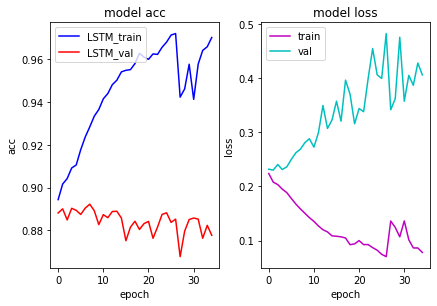

In [ ]:
s, (at, al) = plt.subplots(1, 2)
s.tight_layout()
at.plot(historyLiarReduceLROnPlateau.history['acc'], c= 'b')
at.plot(historyLiarReduceLROnPlateau.history['val_acc'], c='r')
at.set_title('model acc')
at.set_ylabel('acc')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(historyLiarReduceLROnPlateau.history['loss'], c='m')
al.plot(historyLiarReduceLROnPlateau.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
liarModelReduceLROnPlateau.summary()
#plot_model(liarModelReduceLROnPlateau, "liarModelReduceLROnPlateauArchitecture.png", show_shapes=True)

Model: "model_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 30)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 30, 300)           15577200  
                                                                 
 spatial_dropout1d_48 (Spati  (None, 30, 300)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_48 (Conv1D)          (None, 26, 64)            96064     
                                                                 
 bidirectional_48 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dense_270 (Dense)           (None, 624)               804

#Model for sarcasm detection

##Concatenate the modified one

In [ ]:
combined=np.concatenate((modifiedSemeval_sarcasms.values, modifiedSemeval_rephrases.values), axis=0)
combined.shape

(4335, 3)

In [ ]:
combinedSemeval=pd.DataFrame(combined, columns=["TheStatement", "sarcastic", "Label"])
combinedSemeval.head()

,TheStatement,sarcastic,Label
0,The only thing I got from college is a caffein...,1,FALSE
1,I love it when professors draw a big question ...,1,FALSE
2,Remember the hundred emails from companies whe...,1,FALSE
3,Today my pop-pop told me I was not “forced” to...,1,FALSE
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,FALSE


###Preprocessing

In [ ]:
combinedSemeval.drop(combinedSemeval.columns[[2]], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Non-sarcasm vs sarcasm in combinedSemeval dataset')

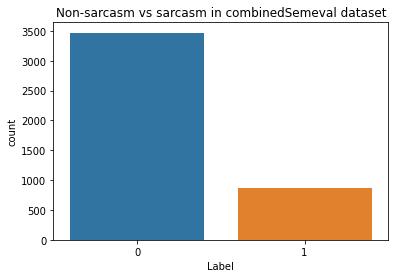

In [ ]:
sns.countplot(combinedSemeval.sarcastic)
plt.xlabel('Label')
plt.title('Non-sarcasm vs sarcasm in combinedSemeval dataset')

In [ ]:
combinedSemeval=combinedSemeval.dropna()

##Preparing the test and dev sets

In [ ]:
combinedSemeval.columns

Index(['TheStatement', 'sarcastic'], dtype='object')

In [ ]:
combinedSemevalTrain, combinedSemevalTest = train_test_split(combinedSemeval, test_size=0.25, random_state=40)

In [ ]:
combinedSemeval.shape

(4334, 2)

In [ ]:
print("Shape of Semeval train portion for features: {}".format(combinedSemevalTrain.shape)) 
print("Shape of Semeval test portion for features: {}".format(combinedSemevalTest.shape)) 

Shape of Semeval train portion for features: (3250, 2)
Shape of Semeval test portion for features: (1084, 2)


##**LSTM**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(combinedSemevalTrain.TheStatement)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 10055


In [ ]:
MAX_SEQUENCE_LENGTH = 40
combinedSemevalXTrain = pad_sequences(tokenizer.texts_to_sequences(combinedSemevalTrain.TheStatement),
                        maxlen = MAX_SEQUENCE_LENGTH)
combinedSemevalXTest = pad_sequences(tokenizer.texts_to_sequences(combinedSemevalTest.TheStatement),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",combinedSemevalXTrain.shape)
print("Testing X Shape:",combinedSemevalXTest.shape)

Training X Shape: (3250, 40)
Testing X Shape: (1084, 40)


In [ ]:
labels = combinedSemevalTrain.sarcastic.unique().tolist()

In [ ]:
encoder = preprocessing.LabelEncoder()
encoder.fit(combinedSemevalTrain.sarcastic.to_list())

combinedSemevalYTrain = encoder.transform(combinedSemevalTrain.sarcastic.to_list())
combinedSemevalYTest = encoder.transform(combinedSemevalTest.sarcastic.to_list())

combinedSemevalYTrain = combinedSemevalYTrain.reshape(-1,1)
combinedSemevalYTest = combinedSemevalYTest.reshape(-1,1)

print("combinedSemevalYTrain shape:", combinedSemevalYTrain.shape)
print("combinedSemevalYTestt shape:", combinedSemevalYTest.shape)

combinedSemevalYTrain shape: (3250, 1)
combinedSemevalYTestt shape: (1084, 1)


In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [ ]:
#!ls
#!pwd

In [ ]:
#indexing word vectors

embeddings_index = {}
f = open('/content/drive/MyDrive/Thesis/Datasets/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


LSTM implement

###Word Embedding

In [ ]:
EMBEDDING_DIM = 300

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

###Building the model

In [ ]:
sequence_inputSemeval = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequencesSemeval = embedding_layer(sequence_inputSemeval)
x = SpatialDropout1D(0.2)(embedding_sequencesSemeval)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
outputSemeval = Dense(1, activation='tanh')(x)

By using Model library and compiling with Adam optimizer, **LR**=____, loss function=binary_crossentropy 

In [ ]:
LR = 1e-3

In [ ]:
semevalModelEarlyStopping = tf.keras.Model(sequence_inputSemeval, outputSemeval)
semevalModelEarlyStopping.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['acc', f1_m, precision_m , recall_m])

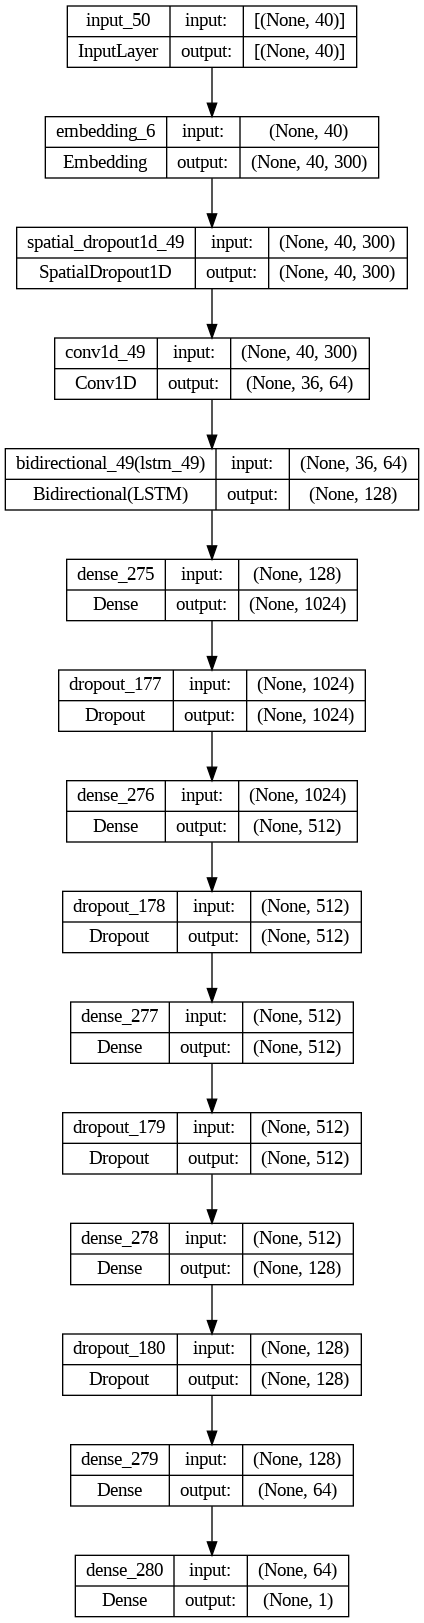

In [ ]:
plot_model(semevalModelEarlyStopping, "semevalModelEarlyStoppingArchitecture.png", show_shapes=True)

In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

In [ ]:
BATCH_SIZE = 200
EPOCHS = 200

###Training With EarlyStopping

In [ ]:
from imblearn.over_sampling import SMOTE
smt=SMOTE()

In [ ]:
combinedSemevalXTrain, combinedSemevalYTrain=smt.fit_resample(combinedSemevalXTrain, combinedSemevalYTrain)

In [ ]:
combinedSemevalXTrain.shape

(5174, 40)

In [ ]:
historySemevalEarlyStopping = semevalModelEarlyStopping.fit(combinedSemevalXTrain, combinedSemevalYTrain, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(combinedSemevalXTest, combinedSemevalYTest), callbacks=EarlyStopping)

Epoch 1/200
26/26 [==============================] - 13s 323ms/step - loss: 0.8497 - acc: 0.5151 - f1_m: 0.4407 - precision_m: 0.4976 - recall_m: 0.5110 - val_loss: 0.6290 - val_acc: 0.7721 - val_f1_m: 0.1106 - val_precision_m: 0.1997 - val_recall_m: 0.0794
Epoch 2/200
26/26 [==============================] - 8s 290ms/step - loss: 0.6837 - acc: 0.5655 - f1_m: 0.5502 - precision_m: 0.5754 - recall_m: 0.5504 - val_loss: 0.5673 - val_acc: 0.7823 - val_f1_m: 0.1317 - val_precision_m: 0.2652 - val_recall_m: 0.0904
Epoch 3/200
26/26 [==============================] - 8s 302ms/step - loss: 0.6374 - acc: 0.6477 - f1_m: 0.6386 - precision_m: 0.6571 - recall_m: 0.6325 - val_loss: 0.5591 - val_acc: 0.7186 - val_f1_m: 0.1879 - val_precision_m: 0.2082 - val_recall_m: 0.1757
Epoch 4/200
26/26 [==============================] - 8s 307ms/step - loss: 0.5990 - acc: 0.6867 - f1_m: 0.6809 - precision_m: 0.6975 - recall_m: 0.6830 - val_loss: 0.6203 - val_acc: 0.6485 - val_f1_m: 0.2477 - val_precision_m: 0

In [ ]:
loss, acc, f1_score, precision, recall = semevalModelEarlyStopping.evaluate(combinedSemevalXTest, combinedSemevalYTest, verbose=2)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("f1 score: {}".format(f1_score))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

34/34 - 1s - loss: 0.5512 - acc: 0.7500 - f1_m: 0.1140 - precision_m: 0.1456 - recall_m: 0.0998 - 661ms/epoch - 19ms/step
Loss: 0.5511524081230164
Accuracy: 0.75
f1 score: 0.11404997110366821
Precision: 0.1455882489681244
Recall: 0.09983480721712112


In [ ]:
print(semevalModelEarlyStopping.summary())

Model Evaluating

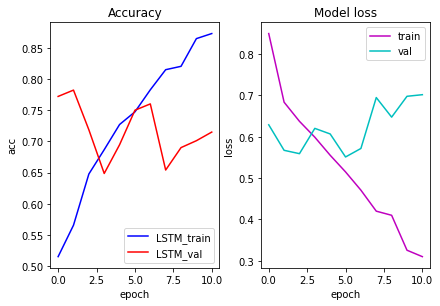

In [ ]:
s, (at, al) = plt.subplots(1,2)
s.tight_layout()
at.plot(historySemevalEarlyStopping.history['acc'], c= 'b')
at.plot(historySemevalEarlyStopping.history['val_acc'], c='r')
at.set_title('Accuracy')
at.set_ylabel('acc')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='lower right')

al.plot(historySemevalEarlyStopping.history['loss'], c='m')
al.plot(historySemevalEarlyStopping.history['val_loss'], c='c')
al.set_title('Model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper right')

###Training With ReduceLRonPlateau

In [ ]:
LR=1e-5

In [ ]:
semevalModelReduceLROnPlateau = tf.keras.Model(sequence_inputSemeval, outputSemeval)
semevalModelReduceLROnPlateau.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['acc', f1_m, precision_m , recall_m])

In [ ]:
historySemevalReduceLROnPlateau = semevalModelReduceLROnPlateau.fit(combinedSemevalXTrain, combinedSemevalYTrain, batch_size=BATCH_SIZE, epochs=50,
                    validation_data=(combinedSemevalXTest, combinedSemevalYTest), callbacks=ReduceLROnPlateau)

Epoch 1/50
26/26 [==============================] - 13s 328ms/step - loss: 0.4673 - acc: 0.7899 - f1_m: 0.7797 - precision_m: 0.8155 - recall_m: 0.7499 - val_loss: 0.5811 - val_acc: 0.7232 - val_f1_m: 0.1896 - val_precision_m: 0.2172 - val_recall_m: 0.1719 - lr: 1.0000e-05
Epoch 2/50
26/26 [==============================] - 8s 292ms/step - loss: 0.4611 - acc: 0.7903 - f1_m: 0.7866 - precision_m: 0.8003 - recall_m: 0.7748 - val_loss: 0.5752 - val_acc: 0.7334 - val_f1_m: 0.1905 - val_precision_m: 0.2274 - val_recall_m: 0.1665 - lr: 1.0000e-05
Epoch 3/50
26/26 [==============================] - 8s 291ms/step - loss: 0.4649 - acc: 0.7831 - f1_m: 0.7747 - precision_m: 0.8078 - recall_m: 0.7468 - val_loss: 0.5836 - val_acc: 0.7242 - val_f1_m: 0.1882 - val_precision_m: 0.2131 - val_recall_m: 0.1713 - lr: 1.0000e-05
Epoch 4/50
26/26 [==============================] - 8s 302ms/step - loss: 0.4634 - acc: 0.7870 - f1_m: 0.7804 - precision_m: 0.8033 - recall_m: 0.7608 - val_loss: 0.5853 - val_acc:

In [ ]:
loss, acc, f1_score, precision, recall = semevalModelReduceLROnPlateau.evaluate(combinedSemevalXTest, combinedSemevalYTest, verbose=2)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("f1 score: {}".format(f1_score))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

34/34 - 1s - loss: 0.6171 - acc: 0.7288 - f1_m: 0.1437 - precision_m: 0.1641 - recall_m: 0.1554 - 679ms/epoch - 20ms/step
Loss: 0.6170700192451477
Accuracy: 0.7287822961807251
f1 score: 0.1437252312898636
Precision: 0.16405229270458221
Recall: 0.1553652286529541


Model Evaluation

In [ ]:
s, (at, al) = plt.subplots(1, 2)
s.tight_layout()
at.plot(historySemevalReduceLROnPlateau.history['acc'], c= 'b')
at.plot(historySemevalReduceLROnPlateau.history['val_acc'], c='r')
at.set_title('model acc')
at.set_ylabel('acc')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(historySemevalReduceLROnPlateau.history['loss'], c='m')
al.plot(historySemevalReduceLROnPlateau.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
"""historySemevalReduceLROnPlateau.summary()"""
#plot_model(liarModelReduceLROnPlateau, "liarModelReduceLROnPlateauArchitecture.png", show_shapes=True)

wordcloud for combined liar dataset

#Model For emotion detection

In [ ]:
pd.set_option('display.max_colwidth', -1)

###Preprocessing

In [ ]:
tweet.head()

In [ ]:
tweet.shape

(40000, 3)

In [ ]:
tweet=tweet.dropna()
tweet.shape

(40000, 3)

In [ ]:
tweet['content'] = tweet['content'].apply(lambda x: x.lower())
tweet['content'] = tweet['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [ ]:
max_words = 2000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(tweet['content'].values)
X = tokenizer.texts_to_sequences(tweet['content'].values)
# print(data['clean_tweet'][:5])
# print('Tokenized sentences', X[:5])
X = pad_sequences(X, maxlen=32)
# print(X[:5])
print(X.shape[1])

32


In [ ]:
dummies = pd.get_dummies(tweet['sentiment'])
Y = dummies.values
tweetXTrain, tweetXTest, tweetYTrain, tweetYTest = train_test_split(X,Y, test_size = 0.25, random_state = 40)
print(tweetXTrain.shape,tweetYTrain.shape)
print(tweetXTest.shape,tweetYTest.shape)

(30000, 32) (30000, 13)
(10000, 32) (10000, 13)


###Dictionary for emotion words

In [ ]:
dict_emotion = {}
dict_label = {}
for i in range(len(Y)):
    dict_emotion[tweet['sentiment'][i]] = np.argmax(Y[i])
    dict_label[np.argmax(Y[i])] = tweet['sentiment'][i]
    if len(dict_emotion) == 13:
        print('Break at: ', i)
        break
#     print(data['sentiment'][i], '->', Y[i])
print(dict_emotion, dict_label)

Break at:  494
{'empty': 2, 'sadness': 10, 'enthusiasm': 3, 'neutral': 8, 'worry': 12, 'surprise': 11, 'love': 7, 'fun': 4, 'hate': 6, 'happiness': 5, 'boredom': 1, 'relief': 9, 'anger': 0} {2: 'empty', 10: 'sadness', 3: 'enthusiasm', 8: 'neutral', 12: 'worry', 11: 'surprise', 7: 'love', 4: 'fun', 6: 'hate', 5: 'happiness', 1: 'boredom', 9: 'relief', 0: 'anger'}


In [ ]:
X_val = tweetXTrain[:500]
Y_val = tweetYTrain[:500]
partial_X_train = tweetXTrain[500:]
partial_Y_train = tweetYTrain[500:]

###Training with Early Stopping

In [ ]:
embedding_out_dim = 256
lstm_out_dim = 256

modelTweetEarlyStopping = Sequential()
modelTweetEarlyStopping.add(Embedding(max_words, embedding_out_dim,input_length = X.shape[1]))
modelTweetEarlyStopping.add(LSTM(lstm_out_dim+1))
modelTweetEarlyStopping.add(Dense(13,activation='softmax'))
modelTweetEarlyStopping.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy', f1_m, precision_m , recall_m])

In [ ]:
# train the net
batch_size = 512
historyTweetEarlyStopping = modelTweetEarlyStopping.fit(tweetXTrain,tweetYTrain, 
                    epochs = 50, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val), callbacks=EarlyStopping)

Epoch 1/50
59/59 [==============================] - 5s 33ms/step - loss: 2.1636 - accuracy: 0.2413 - f1_m: 0.0018 - precision_m: 0.0505 - recall_m: 9.2691e-04 - val_loss: 2.0728 - val_accuracy: 0.2920 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
59/59 [==============================] - 1s 22ms/step - loss: 1.9699 - accuracy: 0.3263 - f1_m: 0.0450 - precision_m: 0.5418 - recall_m: 0.0238 - val_loss: 1.8743 - val_accuracy: 0.3600 - val_f1_m: 0.0852 - val_precision_m: 0.5750 - val_recall_m: 0.0460
Epoch 3/50
59/59 [==============================] - 1s 22ms/step - loss: 1.8504 - accuracy: 0.3746 - f1_m: 0.1235 - precision_m: 0.5834 - recall_m: 0.0698 - val_loss: 1.8009 - val_accuracy: 0.4120 - val_f1_m: 0.1678 - val_precision_m: 0.6667 - val_recall_m: 0.0960
Epoch 4/50
59/59 [==============================] - 1s 22ms/step - loss: 1.7847 - accuracy: 0.4006 - f1_m: 0.1892 - precision_m: 0.5868 - recall_m: 0.1134 - val_loss: 1.7728 - val_accuracy:

In [ ]:
print(modelTweetEarlyStopping.summary())

####Evaluation

In [ ]:
loss, acc, f1_score, precision, recall = modelTweetEarlyStopping.evaluate(X_val, Y_val, verbose=0)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("f1 score: {}".format(f1_score))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Loss: 0.18253673613071442
Accuracy: 0.949999988079071
f1 score: 0.9489916563034058
Precision: 0.9745522737503052
Recall: 0.92578125


Model Evaluating

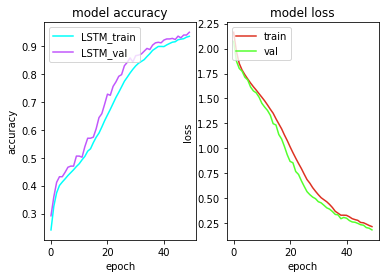

In [ ]:
s, (at, al) = plt.subplots(1, 2)
at.plot(historyTweetEarlyStopping.history['accuracy'], color= '#00fffc')
at.plot(historyTweetEarlyStopping.history['val_accuracy'], color='#c157fc')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(historyTweetEarlyStopping.history['loss'], color= '#dd3222')
al.plot(historyTweetEarlyStopping.history['val_loss'], color= '#54ff2d')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

###Training with ReduceLROnPlatau

In [ ]:
embedding_out_dim = 256
lstm_out_dim = 256

modelTweetReduceLROnPlateau = Sequential()
modelTweetReduceLROnPlateau.add(Embedding(max_words, embedding_out_dim,input_length = X.shape[1]))
modelTweetReduceLROnPlateau.add(LSTM(lstm_out_dim+1))
modelTweetReduceLROnPlateau.add(Dense(13,activation='softmax'))
modelTweetReduceLROnPlateau.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy', f1_m, precision_m , recall_m])

In [ ]:
# train the net
batch_size = 512
historyTweetReduceLROnPlateau = modelTweetReduceLROnPlateau.fit(tweetXTrain,tweetYTrain, 
                    epochs = 50, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val), callbacks=ReduceLROnPlateau)

####Evaluation

In [ ]:
loss, acc, f1_score, precision, recall = modelTweetReduceLROnPlateau.evaluate(X_val, Y_val, verbose=0)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("f1 score: {}".format(f1_score))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Loss: 0.17797110974788666
Accuracy: 0.9440000057220459
f1 score: 0.9489878416061401
Precision: 0.993678092956543
Recall: 0.909375011920929


Model Evaluating

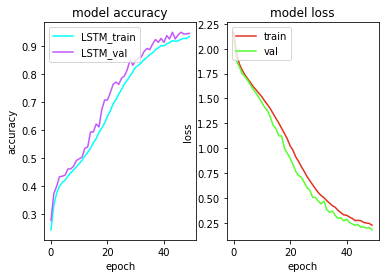

In [ ]:
s, (at, al) = plt.subplots(1, 2)
at.plot(historyTweetReduceLROnPlateau.history['accuracy'], color= '#00fffc')
at.plot(historyTweetReduceLROnPlateau.history['val_accuracy'], color='#c157fc')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(historyTweetReduceLROnPlateau.history['loss'], color= '#dd3222')
al.plot(historyTweetReduceLROnPlateau.history['val_loss'], color= '#54ff2d')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
plot_model(modelTweetReduceLROnPlateau, "modelTweetReduceLROnPlateauArchitecture.png", show_shapes=True)

In [ ]:
from tensorflow.keras.layers import Input, Dense, concatenate

In [ ]:
#Merging model A and B
Combined = concatenate([outputs, semevalModelEarlyStopping, modelTweetReduceLROnPlateau], name="CombinedLayer")

#Final Layer
OutputLayer = Dense(16, activation = "sigmoid", name = "OutputLayer")(Combined)

#Model Definition 
merged = Model(inputs=[(sequence_input, semevalModelEarlyStopping.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1])) ,modelTweetReduceLROnPlateau.add(Embedding(max_words, embedding_out_dim,input_length = X.shape[1])))],outputs=[OutputLayer], name = "merged model")

#Model Details
merged.summary()

ValueError: ignored

In [ ]:
plot_model(merged, "combinedArchitecture.png", show_shapes=True)